# Exploración de la epidemia de Covid19 en México

Casos de estudio reportados por la Secretaria de Salud de pacientes sospechos y confirmados de SARS-Cov2.

Tomados de https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico.

In [1]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import integrate, linalg, optimize, interpolate, loadtxt
from scipy import pi,array,zeros,eye,special,misc
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(13,8)})

In [2]:
# lectura de datos
ruta = r'C:\Users\Luis Omar\Documents\Codigos\cov19\cov19\covid19_consolidado.csv'
covid19 = pd.read_csv(ruta, encoding='latin-1',
                      parse_dates=['FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS',
                                   'FECHA_DEF', 'FECHA_ACTUALIZACION_PREV', 'FECHA_DEF_PREV'])
covid19['FECHA_DEF'] = pd.to_datetime(covid19['FECHA_DEF'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_DEF_PREV'] = pd.to_datetime(covid19['FECHA_DEF_PREV'], format='%Y-%m-%d', errors='coerce')


In [3]:
# Estadistica descriptiva
covid19.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI,RESULTADO_PREV
count,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,...,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000
mean,1.636959,9.626616,14.884568,1.510854,16.367790,15.166463,37.130726,1.237322,74.452592,1.832788,...,2.473125,2.335193,2.191198,2.325677,2.273452,32.313355,1.859677,98.569036,74.450929,1.895572
std,0.480877,7.749124,7.962399,0.499883,11.610796,7.866836,48.102958,0.425442,40.440818,0.595132,...,6.975689,5.876445,5.859293,5.766722,5.902751,45.357832,0.689633,6.461983,40.444198,0.704472
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,9.000000,1.000000,9.000000,9.000000,7.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,99.000000,97.000000,1.000000
50%,2.000000,12.000000,14.000000,2.000000,15.000000,15.000000,20.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000,2.000000
75%,2.000000,12.000000,21.000000,2.000000,21.000000,21.000000,48.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,99.000000,97.000000,2.000000
max,2.000000,99.000000,32.000000,2.000000,99.000000,32.000000,999.000000,2.000000,99.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000,99.000000,3.000000


In [4]:
# tipos de datos
covid19.dtypes

FECHA_ACTUALIZACION         datetime64[ns]
ID_REGISTRO                         object
ORIGEN                               int64
SECTOR                               int64
ENTIDAD_UM                           int64
SEXO                                 int64
ENTIDAD_NAC                          int64
ENTIDAD_RES                          int64
MUNICIPIO_RES                      float64
TIPO_PACIENTE                        int64
FECHA_INGRESO               datetime64[ns]
FECHA_SINTOMAS              datetime64[ns]
FECHA_DEF                   datetime64[ns]
INTUBADO                             int64
NEUMONIA                             int64
EDAD                                 int64
NACIONALIDAD                         int64
EMBARAZO                             int64
HABLA_LENGUA_INDIG                   int64
DIABETES                             int64
EPOC                                 int64
ASMA                                 int64
INMUSUPR                             int64
HIPERTENSIO

In [5]:
covid19.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,FECHA_ACTUALIZACION_PREV,RESULTADO_PREV,FECHA_DEF_PREV
0,2020-06-02,16169f,2,3,27,2,27,27,13.0,1,...,2,2,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
1,2020-06-02,1009bf,2,4,14,2,14,14,39.0,1,...,2,99,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
2,2020-06-02,05d103,2,4,9,2,9,9,7.0,1,...,2,99,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
3,2020-06-02,0d01b5,2,4,25,1,25,25,6.0,2,...,2,99,1,99,MÃ©xico,99,2,2020-06-01,1,2020-04-22
4,2020-06-02,002746,2,4,13,2,13,15,81.0,2,...,2,99,1,99,MÃ©xico,99,2,2020-06-01,1,2020-04-26


In [7]:
covid19.groupby(['FECHA_INGRESO', 'RESULTADO'], as_index=False).agg({'ID_REGISTRO':'count'})

,FECHA_INGRESO,RESULTADO,ID_REGISTRO
0,2020-01-01,2,5
1,2020-01-02,2,16
2,2020-01-03,2,18
3,2020-01-04,2,6
4,2020-01-05,2,14
...,...,...,...
345,2020-06-01,2,260
346,2020-06-01,3,8377
347,2020-06-02,1,15
348,2020-06-02,2,1


In [11]:
covid19.groupby(['FECHA_INGRESO', 'RESULTADO'], as_index=False).agg({'ID_REGISTRO':'count'})

,FECHA_INGRESO,RESULTADO,ID_REGISTRO
0,2020-01-01,2,5
1,2020-01-02,2,16
2,2020-01-03,2,18
3,2020-01-04,2,6
4,2020-01-05,2,14
...,...,...,...
345,2020-06-01,2,260
346,2020-06-01,3,8377
347,2020-06-02,1,15
348,2020-06-02,2,1


In [12]:
conteo_fs = covid19.groupby(['FECHA_SINTOMAS', 'RESULTADO'], as_index=False).agg({'ID_REGISTRO':'count'})

In [22]:
conteo_fs.columns = ['FECHA_SINTOMAS', 'RESULTADO', 'NUM_CASOS']

Perfil de los datos por fecha de inicio de sintomas

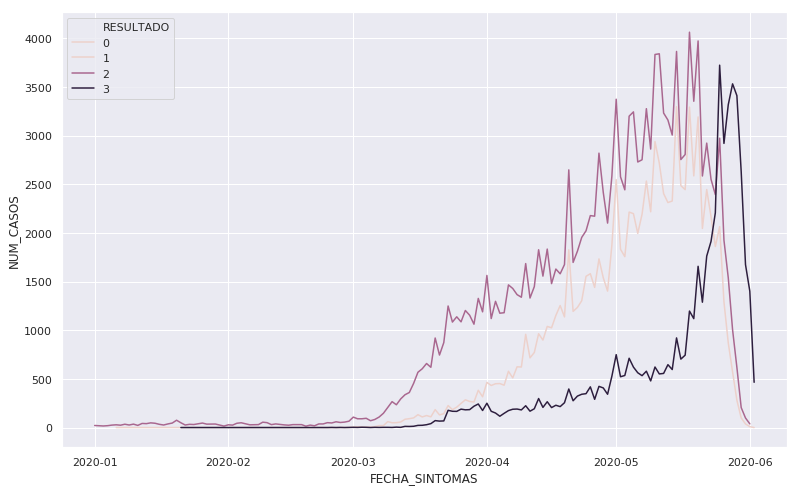

In [24]:
sns.lineplot(x="FECHA_SINTOMAS", y="NUM_CASOS", hue="RESULTADO", markers=True, dashes=True, data=conteo_fs);

Casos confirmados

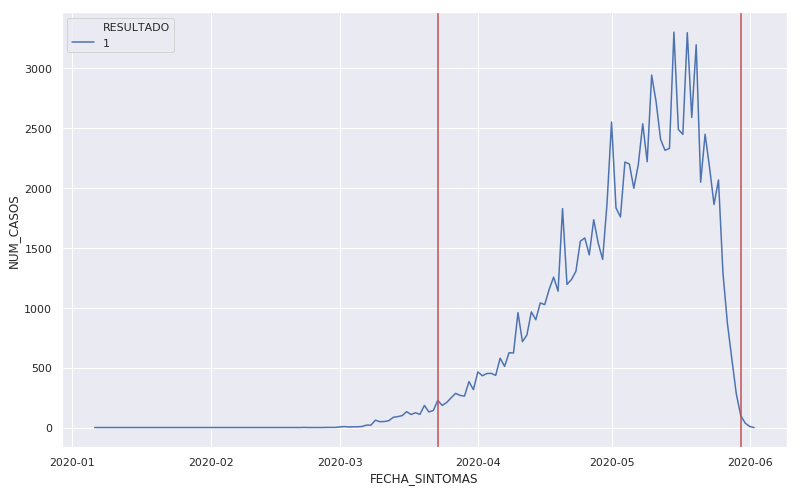

In [66]:
sns.lineplot(x="FECHA_SINTOMAS", y="NUM_CASOS", hue="RESULTADO", data=conteo_fs[conteo_fs.RESULTADO==1]);
plt.axvline('23-03-2020', 0, 3000, color='r');
plt.axvline('30-05-2020', 0, 3000, color='r');

Casos confirmados diarios

In [57]:
covid_diarios = pd.read_csv('/home/ionekr/Documentos/Deformacion/Covid19/Datos/CASOS_DIARIOS_CONF.csv',
                           encoding='latin1')
covid_diarios['FECHA'] = pd.to_datetime(covid_diarios['FECHA'], format='%d-%m-%Y', errors='coerce')

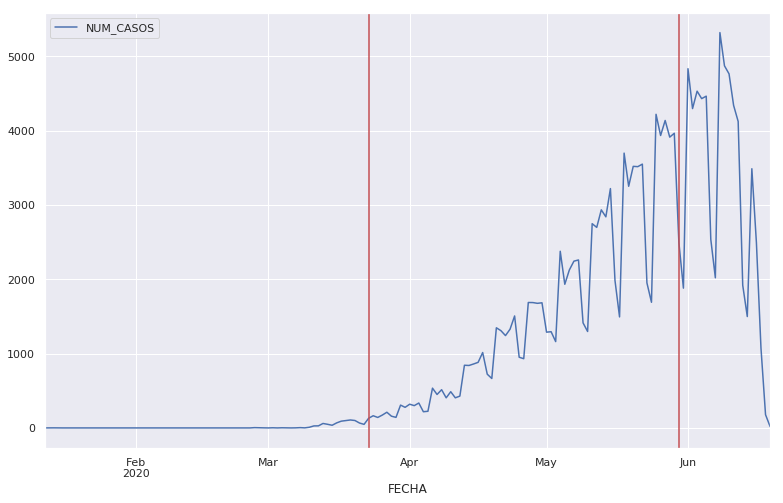

In [67]:
covid_diarios.plot(x='FECHA', y='NUM_CASOS');
plt.axvline('23-03-2020', 0, 3000, color='r');
plt.axvline('30-05-2020', 0, 3000, color='r');

Modelos SEIR, y SIR

In [132]:
# Modelo SEIR
def seir(y, t, p):
    f = np.zeros([4])
    betaIS = p[0]*y[0]*y[2]
    f[0] = -betaIS  # S
    f[1] = betaIS - 0.2*y[1]  # E
    f[2] = 0.2*y[1] - p[1]*y[2]  # I
    f[3] = p[1]*y[2]  # R
    return f

In [69]:
# Modelo SEAIR
def seair(y, t, p):
    f = np.zeros([4])
    betaIS = p[0]*y[0]*y[3]
    f[0] = -betaIS  # S
    f[1] = betaIS - 0.2*y[1]  # E
    f[2] = (1 - p[2])*0.2*y[1] - p[1]*y[2]  # A
    f[3] = p[2]*0.2*y[1] - p[1]*y[3]  # I
    return f

In [80]:
def evaluador(model, t, p, y):
    y = integrate.odeint(model, y, t, args=(p,))
    return y

In [84]:
class Poisson_DataFitter:

    def __init__(self, infectados, modelo, y0,  pu, pl, num_exp, tot_pob):
        self.infectados = infectados
        self.num_datos = len(self.infectados)
        self.tdata = np.linspace(0, self.num_datos, self.num_datos)
        self.logw = np.log(sum(special.factorial(self.infectados)))
        self.pl = pl
        self.pu = pu
        self.modelo = modelo
        self.num_exp = num_exp
        self.tot_pob = tot_pob
        if len(y0) == 4:
            #  Modelo SEIR
            self.ci = np.array([1-((self.num_exp*+1)*y0[0]/self.tot_pob),
                               y0[0]*self.num_exp/self.tot_pob,
                               y0[0]/self.tot_pob, 0.0])
        else:
            #  Modelo SIR
            self.ci = np.array([(1-y0[0]/self.tot_pob),
                               y0[0]/self.tot_pob, 0.0])

    def evaluate(self, p):
        # y0 = integrate.odeint(self.modelo, self.ci, np.linspace(0.0,100.0,2000), args=(p,))[-1,:]        
        ySoln = integrate.odeint(self.modelo, self.ci, self.tdata, args=(p,))
        return ySoln
    
    def residue(self,p):
        ySoln = self.evaluate(p)[:,2]
        ind1 = np.where(ySoln<10**-8)
        ySoln[ind1] = np.ones(len(ind1))
        res = ySoln*self.tot_pob - self.infectados*np.log(ySoln*self.tot_pob) \
            + self.logw
        return sum(res)
    
    def error(self,p):
        try:
            abserror = self.residue(p)
        except ValueError:
            abserror = 10.0**10
        return abserror


In [78]:
conteo_fs[(conteo_fs.RESULTADO==1) & (conteo_fs.FECHA_SINTOMAS>='2020-03-01')].NUM_CASOS.values

array([   6,    9,    6,    7,    7,   10,   21,   21,   62,   50,   51,
         58,   86,   92,  100,  133,  110,  124,  111,  185,  131,  143,
        227,  185,  210,  249,  286,  269,  263,  384,  317,  465,  433,
        451,  453,  436,  579,  511,  625,  623,  959,  717,  772,  965,
        900, 1040, 1026, 1153, 1255, 1138, 1827, 1195, 1235, 1304, 1555,
       1582, 1441, 1734, 1540, 1403, 1878, 2549, 1833, 1757, 2215, 2199,
       1996, 2193, 2534, 2218, 2940, 2718, 2405, 2313, 2329, 3298, 2487,
       2446, 3294, 2587, 3193, 2047, 2447, 2169, 1861, 2066, 1292,  871,
        572,  282,  100,   38,   10,    1])

In [133]:
# Condiciones iniciales
pob_total = 127e6
num_exp = 10
inf_ini = 6
num_asin = 1
i0 = inf_ini/pob_total
e0 = inf_ini*num_exp/pob_total
a0 = 1/pob_total
y0 = np.array([1 - (i0 + e0 + a0), e0, a0, i0])
y0 = np.array([1 - (1+num_exp)*inf_ini/pob_total, num_exp*inf_ini/pob_total,
              inf_ini/pob_total, 0.0])

In [141]:
pu = np.array([2.15, 0.7])
pl = np.array([1.65, 0.5])
infectados = conteo_fs[(conteo_fs.RESULTADO==1) & (conteo_fs.FECHA_SINTOMAS>='2020-03-01')].NUM_CASOS.values
poisson = Poisson_DataFitter(infectados, seir, y0, pu, pl, num_exp, pob_total)

# poisson = Poisson_DataFitter(covid_datos, sir, z0, qu, ql, num_exp, pob_total)
Ninit = 100
pmat = pl + abs(np.random.uniform(size=(Ninit,len(pl))))*(pu-pl)
rop = list(map(poisson.error, pmat))
bestguessindex = np.nonzero(rop==min(rop))
px = pmat[bestguessindex,:][0][0]
q = optimize.fmin(poisson.error, px)


In [142]:
px

array([2.00658042, 0.52977314])

In [143]:
q

array([2.00658042, 0.52977314])

In [144]:
t_eval = np.linspace(0, poisson.num_datos, poisson.num_datos)
res_q = evaluador(seir, t_eval, q, y0)

In [131]:
len(poisson.infectados)

40

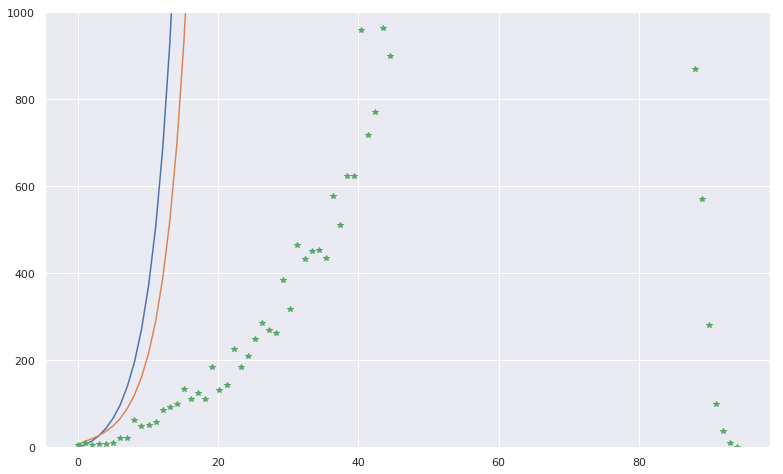

In [145]:
plt.plot(t_eval, res_q[:, 3]*pob_total, t_eval, res_q[:, 2]*pob_total, t_eval, poisson.infectados, '*')
plt.ylim(0, 1000)
plt.show()


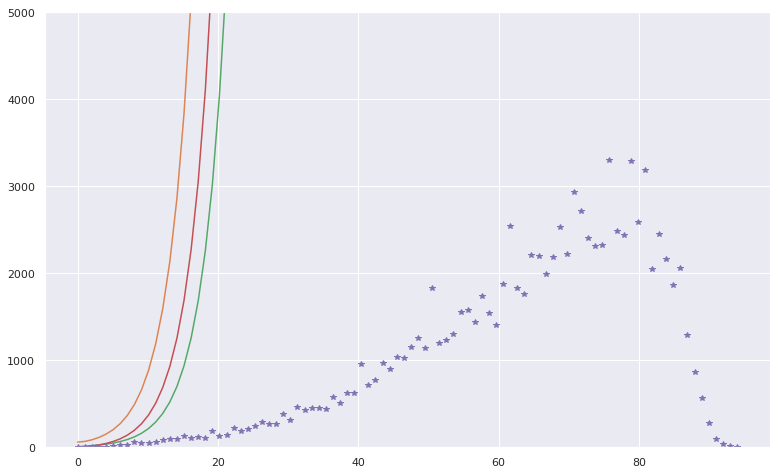

In [147]:
plt.plot(t_eval, res_q[:, 0]*pob_total, t_eval, res_q[:, 1]*pob_total, t_eval, res_q[:, 2]*pob_total,
         t_eval, res_q[:, 3]*pob_total, t_eval, poisson.infectados, '*')
plt.ylim(0, 5000)
plt.show()


Ahora empleando los datos diarios

In [148]:
pu = np.array([2.15, 0.7])
pl = np.array([1.65, 0.5])
infectados = covid_diarios.NUM_CASOS.values
poisson_conf = Poisson_DataFitter(infectados, seir, y0, pu, pl, num_exp, pob_total)
Ninit = 200
pmat = pl + abs(np.random.uniform(size=(Ninit,len(pl))))*(pu-pl)
rop = list(map(poisson_conf.error, pmat))
bestguessindex = np.nonzero(rop==min(rop))
px = pmat[bestguessindex,:][0][0]
q = optimize.fmin(poisson_conf.error, px)


In [152]:
q

array([1.92790101, 0.68639004])

In [157]:
px0 = np.array([2.08949959, 0.59424797])

In [158]:
t_eval = np.linspace(0, poisson_conf.num_datos, poisson_conf.num_datos)
res_q = evaluador(seir, t_eval, px0, y0)

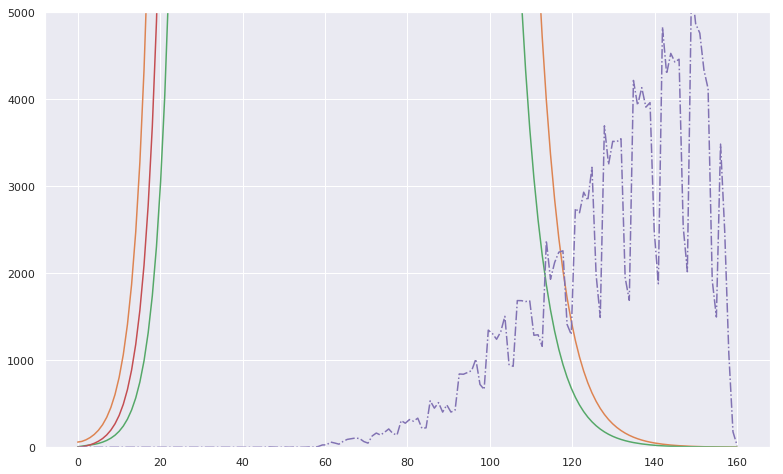

In [161]:
plt.plot(t_eval, res_q[:, 0]*pob_total, t_eval, res_q[:, 1]*pob_total, t_eval, res_q[:, 2]*pob_total,
         t_eval, res_q[:, 3]*pob_total, t_eval, poisson_conf.infectados, '-.')
plt.ylim(0, 5000)
plt.show()